This notebook contains code for a multitask model that predicts veracity and emotion of a review simultaneously.

In [ ]:
# Run this line the first time you run thia notebook.
# If running on Google Colab, resturt runtime after running the cell. 
!python -m pip install Keras==2.3.1 tensorflow==2.1.0

In [2]:
import nltk
import numpy as np
import pandas as pd
import re

from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

Using TensorFlow backend.


In [3]:
def clean_text(text):
    """
    clean_text removes stop words and punctuation and lemmatizes the text.
    """
    text = text.lower()
             
    # Process opeations and common punctuation.           
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    
    # Remove all remaining symbols.
    text = re.sub(r'[^a-z0-9]', ' ', text)
    
    # Remove stopwords and lemmatize.
    text = text.split()
    stop_words = stopwords.words("english")
    text = [tok for tok in text if tok not in stop_words]
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]
    return ' '.join(text)

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [7]:
df = pd.read_csv('../../data/results/amazon_final.csv')

In [8]:
# Only leave relevant entries for the task.
amazon_multi = df[['REVIEW_TEXT', 'PREDICTION', 'VERACITY']].copy()

In [9]:
# Preprocess review texts.
amazon_multi['REVIEW_TEXT'] = amazon_multi['REVIEW_TEXT'].apply(lambda x: clean_text(x))

In [10]:
# Get the number of unique words to choose proper vocabulary size.
all_words = []
for entry in amazon_multi['REVIEW_TEXT']:
  all_words += entry.split()
print('Number of unique words:', len(set(all_words)))

Number of unique words: 21766


In [11]:
vocabulary_size = 21000 
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(amazon_multi['REVIEW_TEXT'])
sequences = tokenizer.texts_to_sequences(amazon_multi['REVIEW_TEXT'])

In [12]:
# Encode outputs.
amazon_multi["PREDICTION"].replace({"joy": 0, "fear": 1, 'neutral': 2, 'anger': 3, 'sadness': 4}, inplace=True)
amazon_multi["VERACITY"].replace({"Fake": 0, "Real": 1}, inplace=True)

In [13]:
# Define output columns.
output_columns_all = ['PREDICTION', 'VERACITY']

In [14]:
# Pad sequences to the MAXLEN length.
MAXLEN = 500
X = pad_sequences(sequences, maxlen=MAXLEN)
y = amazon_multi[output_columns_all]

In [45]:
# Leave 10% of data for test and split training test into training and validation subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1)

In [47]:
# Since data is highly imbalanced, define class weights.
class_weights_categorical = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train['PREDICTION']),
                                                 y_train['PREDICTION'])
class_weights_binary = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train['VERACITY']),
                                                 y_train['VERACITY'])
classes_weights = {'VERACITY': class_weights_binary, 'PREDICTION': class_weights_categorical}

In [76]:
# Define model architecture.
input = Input(shape=(MAXLEN,), name='input')
x = Embedding(input_dim=vocabulary_size, output_dim=2, input_length=MAXLEN)(input)
x = Dropout(0.3)(x)
x = Conv1D(64 , 5, activation='relu')(x)
x = MaxPooling1D(pool_size=4)(x)
x = LSTM(100)(x) 

In [77]:
# Store model outputs.
output_array = [] 
metrics_array = {}
loss_array = {}

binary_output = Dense(1, activation='sigmoid', name='veracity_output')(x)
output_array.append(binary_output)
metrics_array['veracity_output'] = 'binary_accuracy'
loss_array['veracity_output'] = 'binary_crossentropy'

categorical_output = Dense(5, activation='softmax', name='categorical_output')(x)
output_array.append(categorical_output)
metrics_array['categorical_output'] = 'sparse_categorical_accuracy'
loss_array['categorical_output'] = 'sparse_categorical_crossentropy'

In [79]:
model = Model(inputs=input, outputs=output_array)

In [80]:
model.compile(optimizer='adadelta',
              loss=loss_array,
              metrics = metrics_array)

In [81]:
print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 500, 2)       42000       input[0][0]                      
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 500, 2)       0           embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 496, 64)      704         dropout_5[0][0]                  
____________________________________________________________________________________________

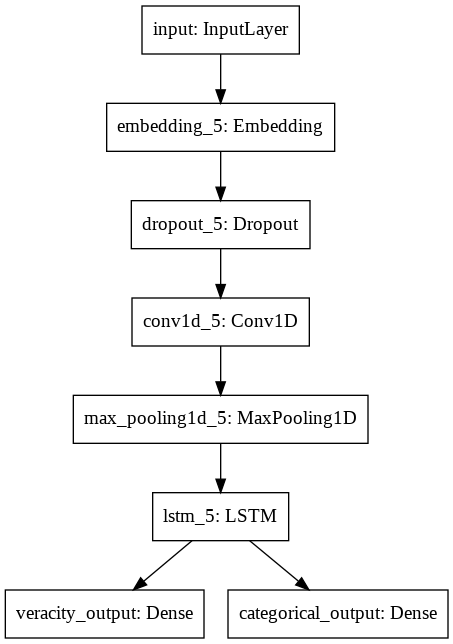

In [82]:
plot_model(model, to_file='model_plot.png')

In [83]:
y_train_output = [y_train['VERACITY'], y_train['PREDICTION']]
y_dev_output = [y_dev['VERACITY'], y_dev['PREDICTION']]

In [84]:
early_stopping_monitor = EarlyStopping(
    monitor='categorical_output_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)


In [85]:
model.fit(X_train, y_train_output,
          epochs=100, 
          batch_size=128,
          class_weight=classes_weights, 
          verbose=1, 
          validation_data=(X_dev,y_dev_output),
          callbacks=[early_stopping_monitor])

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11327 samples, validate on 1259 samples
Epoch 1/100
11327/11327 [==============================] - 44s 4ms/step - loss: 1.9153 - veracity_output_loss: 0.6937 - categorical_output_loss: 1.2208 - veracity_output_binary_accuracy: 0.5130 - categorical_output_sparse_categorical_accuracy: 0.5681 - val_loss: 1.8192 - val_veracity_output_loss: 0.6907 - val_categorical_output_loss: 1.1275 - val_veracity_output_binary_accuracy: 0.5353 - val_categorical_output_sparse_categorical_accuracy: 0.5917
Epoch 2/100
11327/11327 [==============================] - 44s 4ms/step - loss: 1.8582 - veracity_output_loss: 0.6929 - categorical_output_loss: 1.1640 - veracity_output_binary_accuracy: 0.5157 - categorical_output_sparse_categorical_accuracy: 0.5742 - val_loss: 1.7779 - val_veracity_output_loss: 0.6896 - val_categorical_output_loss: 1.0872 - val_veracity_output_binary_accuracy: 0.5353 - val_categorical_output_sparse_categorical_accuracy: 0.5917
Epoch 3/100
11327/11327 [==========================

In [86]:
THRESHOLD = 0.5
y_pred = model.predict(X_test)

# Veracity Output.
y_pred[0][y_pred[0] >= THRESHOLD] = 1
y_pred[0][y_pred[0] < THRESHOLD] = 0
print('Veracity prediction accuracy:\n')
print(classification_report(y_test['VERACITY'], y_pred[0], target_names=['Fake', 'Real']))

# Emotion Classification Output.
y_pred_emo = np.argmax(y_pred[1], axis=1)
print('Emotion classification accuracy:\n')
print(classification_report(y_test['PREDICTION'], y_pred_emo, target_names=['joy', 'fear', 'neutral', 'anger', 'sadness']))

Veracity prediction accuracy:

              precision    recall  f1-score   support

        Fake       0.66      0.68      0.67       758
        Real       0.61      0.59      0.60       641

    accuracy                           0.64      1399
   macro avg       0.64      0.64      0.64      1399
weighted avg       0.64      0.64      0.64      1399

Emotion classification accuracy:

              precision    recall  f1-score   support

         joy       0.86      0.81      0.84       784
        fear       0.17      0.06      0.09        68
     neutral       0.33      0.52      0.40       193
       anger       0.66      0.66      0.66       316
     sadness       0.83      0.26      0.40        38

    accuracy                           0.69      1399
   macro avg       0.57      0.46      0.48      1399
weighted avg       0.71      0.69      0.69      1399



In [87]:
model.save('../../trained_models/multitask_model.h5')